### Loads necessary stuff

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from IPython.display import display # Allows the use of display() for DataFrames
import matplotlib.pyplot as plt
# Pretty display for notebooks
%matplotlib inline


/Library/Python/2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Python/2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### Defines tuning methods

In [2]:
def getTuningParametersAdaBoost():
    params = {'n_estimators': [10, 20, 50, 100, 200],
                  'learning_rate': [1.0, .5, .25, .15]}
    return params

def getTuningParametersLinReg():
    params = {"loss": ["log", "hinge"], "penalty": ["l2", "l1", "elasticnet"]}
    return params

def getTuningParametersDT():
    params = {'criterion': ('gini', 'entropy'),
              'splitter': ('best', 'random')}
    return params

def getTuningParametersRF():
    params = {'n_estimators': [10, 20, 50, 100, 200],
              'criterion': ('gini', 'entropy')}
    return params

def tuneClassifier(clf, X_train, Y_train):
    clfName = clf.__class__.__name__
    parameters = []
    if type(clf) is AdaBoostClassifier:
        parameters = getTuningParametersAdaBoost()
    if type(clf) is SGDClassifier:
        parameters = getTuningParametersLinReg()
    if type(clf) is DecisionTreeClassifier:
        parameters = getTuningParametersDT()
    if type(clf) is RandomForestClassifier:
        parameters = getTuningParametersRF()
    grid_obj = GridSearchCV(estimator=clf, param_grid=parameters,\
                        n_jobs = 4, cv=10)
    grid_obj.fit(X_train, Y_train)
    clf = grid_obj.best_estimator_
    return clf

### Loads the data

In [3]:
### Loads both training and test data
#### DETAIL: THE CLASS IS `Credit-Application-Result`
df_training = pd.read_csv("../training.csv")
df_test = pd.read_csv("../test.csv")
# display(df_training.head())
# display(df_test.head())
# df_complete = pd.concat([df_training, df_test], axis = 0)
# display(df_complete['Credit-Application-Result'])

### Visualizing data

In [4]:
# pd.scatter_matrix(df_training, alpha = 0.3, figsize = (14,8), diagonal = 'kde');

### Counts the number of values for each categorical attribute and also drops those with low variability (<30%)

In [5]:
toRemove = []
for attribute in df_training.columns.values:
#     if df_training[attribute].dtype == object and attribute != 'Credit-Application-Result':
    if attribute != 'Credit-Application-Result':
        count = pd.Series.value_counts(df_training[attribute])
        maxCount = np.max(count)
#         print "max = {}".format(maxCount) 
        variability = 1.0 - (float(maxCount) / count.sum())
        print "{} has a variability of {}".format(attribute, variability)
        if variability < .3:
            toRemove.append(attribute)
#         sumValues = count.sum()
#         variability = 0.0
#         for value in count.columns.values:
#             variability = variability
#         print "{} - sum = {}\n".format(attribute, sumValues)
#         print count
#         print "------------------------------\n\n\n"

print "Features with low variability that will now be removed = {}".format(toRemove)
for att in toRemove:
    df_training.drop(att,axis = 1, inplace = True)
    if att in df_test.columns:
        df_test.drop(att, axis = 1, inplace = True)    

Account-Balance has a variability of 0.476
Duration-of-Credit-Month has a variability of 0.784
Payment-Status-of-Previous-Credit has a variability of 0.48
Purpose has a variability of 0.29
Credit-Amount has a variability of 0.994
Value-Savings-Stocks has a variability of 0.404
Length-of-current-employment has a variability of 0.442
Instalment-per-cent has a variability of 0.508
Guarantors has a variability of 0.086
Duration-in-Current-address has a variability of 0.641025641026
Most-valuable-available-asset has a variability of 0.652
Age-years has a variability of 0.940573770492
Concurrent-Credits has a variability of 0.0
Type-of-apartment has a variability of 0.296
No-of-Credits-at-this-Bank has a variability of 0.36
Occupation has a variability of 0.0
No-of-dependents has a variability of 0.146
Telephone has a variability of 0.4
Foreign-Worker has a variability of 0.038
Features with low variability that will now be removed = ['Purpose', 'Guarantors', 'Concurrent-Credits', 'Type-of-a

### from the previous list of values, we see that `Concurrent-Credits` has only one possible value, and that's why it should be removed

In [6]:
# df_training.drop('Concurrent-Credits', axis=1, inplace=True)
# df_training.drop('Occupation', axis=1, inplace=True)
# df_test.drop('Concurrent-Credits', axis=1, inplace=True)
# df_test.drop('Occupation', axis=1, inplace=True)

### Data cleansing

In [7]:
numInstances = df_training.shape[0]
numAttributes = df_training.shape[1] - 1 #remove the class
classLabel = 'Credit-Application-Result'
### Removes all attributes with more than 50% of the data missing
toRemove = []
for attribute in df_training.columns.values:
    num_missing_values = df_training[attribute].isnull().sum()
#     print "{} has {} missing values".format(attribute, num_missing_values)
    if num_missing_values / numAttributes > .5 and attribute != classLabel:
        print '\t attribute {} has {} missing values, and thus, will be removed!'.format(attribute, num_missing_values)
        toRemove.append(attribute)

### Convert all string stuff into dummies

for attribute in df_test.columns.values:
    if df_test[attribute].dtype == object and attribute != classLabel:
        dummies_training = pd.get_dummies(df_training[attribute], prefix=[attribute])
        dummies_test     = pd.get_dummies(df_test[attribute], prefix=[attribute])        
        df_training      = pd.concat([df_training, dummies_training], axis = 1)
        df_test          = pd.concat([df_test, dummies_test], axis = 1)        
        toRemove.append(attribute)

toRemove = list(set(toRemove))
print 'Attributes to be removed = {}'.format(toRemove)

for attribute in toRemove:
    df_training.drop(attribute, axis=1, inplace=True)
    df_test.drop(attribute, axis=1, inplace=True)

    
    
    
### Works with imputation to replace missing values
for attribute in df_test.columns.values:
    df_training[attribute].fillna((df_training[attribute].mean()), inplace=True)
    df_test[attribute].fillna((df_test[attribute].mean()), inplace=True)


# display(df_training.head())
# display(df_test.head())
# print df_training.shape
# print df_test.shape
        
# mean = np.mean(df_training['Age-years'])
# print "age-years mean = {0:.2f}".format(mean)


# pd.scatter_matrix(df_training, alpha = 0.3, figsize = (14,8), diagonal = 'kde')

	 attribute Duration-in-Current-address has 344 missing values, and thus, will be removed!
	 attribute Age-years has 12 missing values, and thus, will be removed!
Attributes to be removed = ['Duration-in-Current-address', 'Length-of-current-employment', 'Value-Savings-Stocks', 'Account-Balance', 'Age-years', 'Payment-Status-of-Previous-Credit', 'No-of-Credits-at-this-Bank']


### Correlation check

/Library/Python/2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


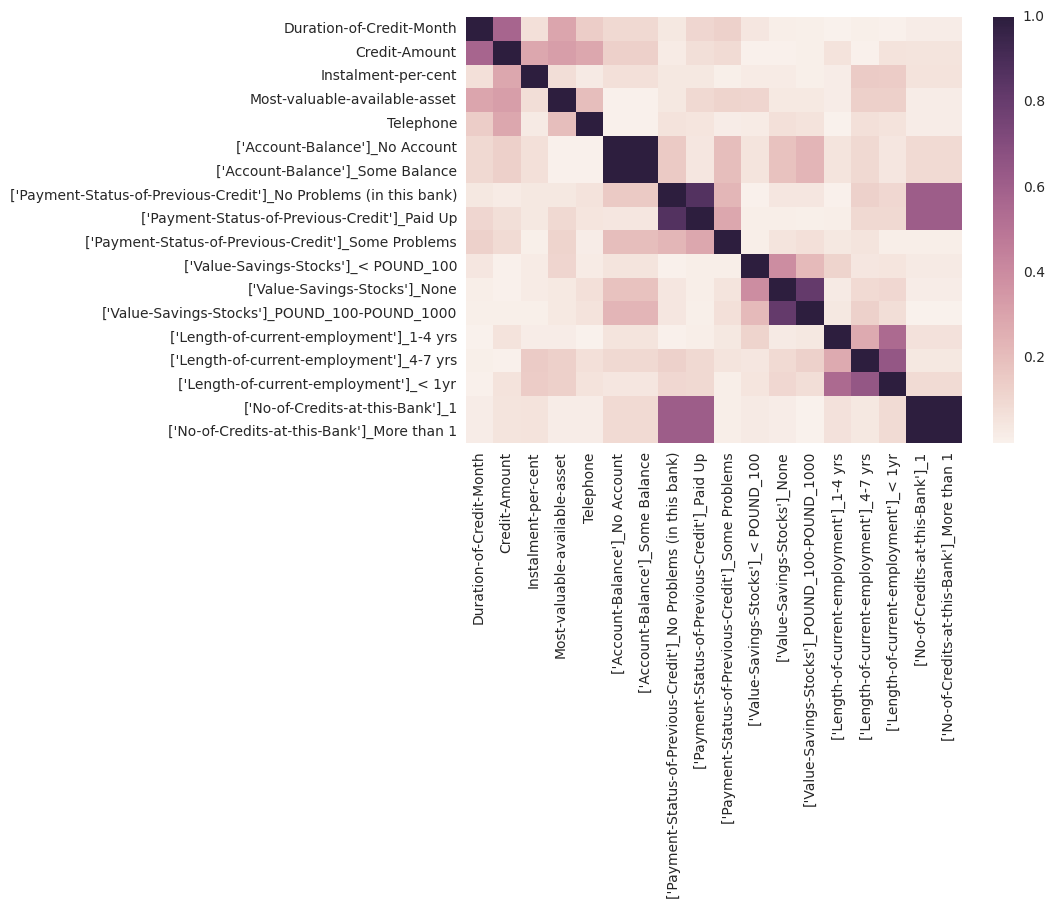

In [8]:
toRemoveCorrelation = []
df_correlation = df_training.drop('Credit-Application-Result', axis = 1)# display(df_training.corr())
df_correlation = df_correlation.corr().abs()

#### PLOTS THIS AS A HEATMAP
import seaborn as sns
sns.heatmap(df_correlation, 
            xticklabels=df_correlation.columns.values,
            yticklabels=df_correlation.columns.values)




In [9]:
## Checks each pair to find which should be removed
for att in df_correlation.columns.values:
    for att2 in df_correlation.columns.values:
        if att != att2:
            value = df_correlation.get_value(att, att2)
            if value > 0.7:
#                 print "correl({}, {}) = {}".format(att, att2, value)
                removeAtt = att
                if att2 < att:
                    removeAtt = att2
                toRemoveCorrelation.append(removeAtt)
toRemoveCorrelation = list(set(toRemoveCorrelation))
print "Highly correlated features to be removed = {}".format(toRemoveCorrelation)

for att in toRemoveCorrelation:
    df_training.drop(att, axis=1, inplace=True)
    df_test.drop(att, axis=1, inplace=True)

Highly correlated features to be removed = ["['Account-Balance']_No Account", "['Payment-Status-of-Previous-Credit']_No Problems (in this bank)", "['No-of-Credits-at-this-Bank']_1", "['Value-Savings-Stocks']_None"]


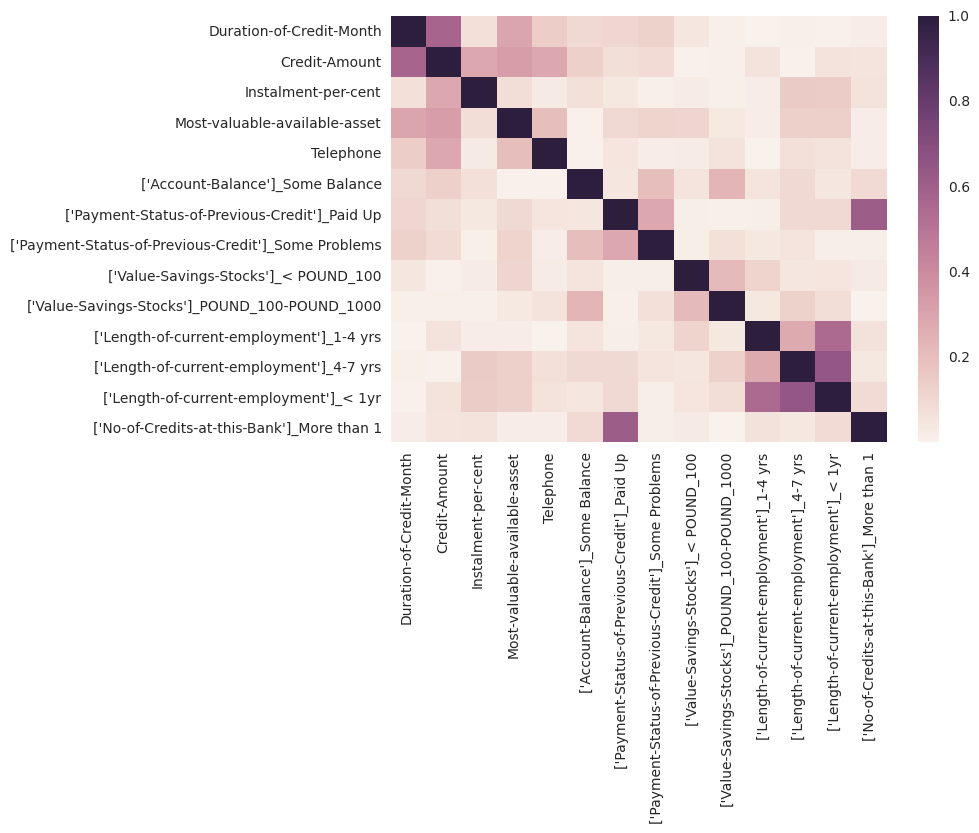

In [10]:
df_correlation = df_training.drop('Credit-Application-Result', axis = 1)
df_correlation = df_correlation.corr().abs()

#### PLOTS THIS AS A HEATMAP
import seaborn as sns
sns.heatmap(df_correlation, 
            xticklabels=df_correlation.columns.values,
            yticklabels=df_correlation.columns.values)

### Splits the data into training and testing sets

In [11]:
### It happens that "['Purpose']_Other" appears in the training set but not in the test, so let's remove it
# df_training.drop("['Purpose']_Other", axis = 1, inplace = True)
  
 
### Splits the data into training and testing structures
X_train = df_training.drop(classLabel, axis = 1)
X_test  = df_test
Y_train = df_training[classLabel]

print X_train.columns.values

## Just in case:
print X_train.shape
print X_test.shape
print Y_train.shape

['Duration-of-Credit-Month' 'Credit-Amount' 'Instalment-per-cent'
 'Most-valuable-available-asset' 'Telephone'
 "['Account-Balance']_Some Balance"
 "['Payment-Status-of-Previous-Credit']_Paid Up"
 "['Payment-Status-of-Previous-Credit']_Some Problems"
 "['Value-Savings-Stocks']_< POUND_100"
 "['Value-Savings-Stocks']_POUND_100-POUND_1000"
 "['Length-of-current-employment']_1-4 yrs"
 "['Length-of-current-employment']_4-7 yrs"
 "['Length-of-current-employment']_< 1yr"
 "['No-of-Credits-at-this-Bank']_More than 1"]
(500, 14)
(500, 14)
(500,)


### Trains the classifiers

Tuning DT...
	 DT tuned!
DT had an accuracy of 63.0303030303% on the validation score
Importances 
 [ 0.18942331  0.21682593  0.0925294   0.13300816  0.05808321  0.06067437
  0.02815204  0.0340511   0.02633218  0.03036171  0.00889552  0.02088512
  0.03224603  0.06853192]


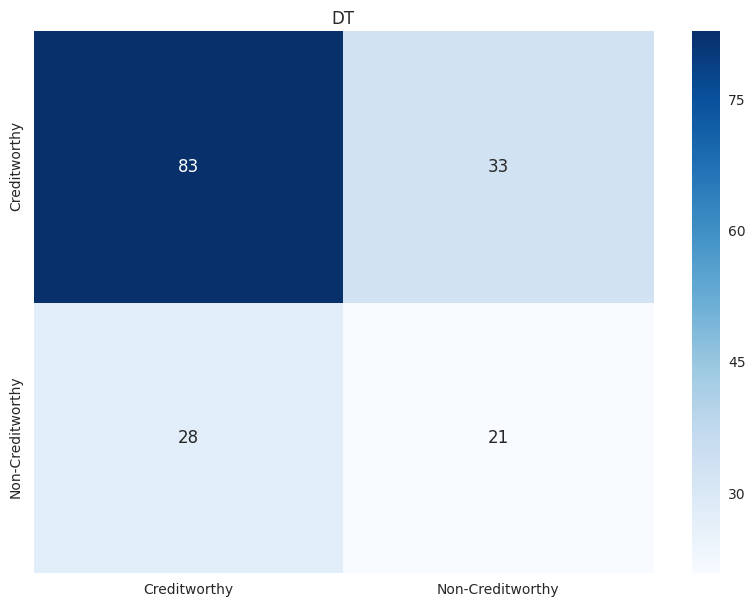

array([ 1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,
        1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,
        1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,
        1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,
        1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,
        0.,  1.,  0.,  0.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,
        1.,  0.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        0.,  1.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.])

Size of X = (165, 14), 	 size of Y = (165,)
FPR: [ 0.          0.57142857  1.        ] 	 TPR: [ 0.          0.71551724  1.        ] 	 Thresholds = [ 2.  1.  0.]


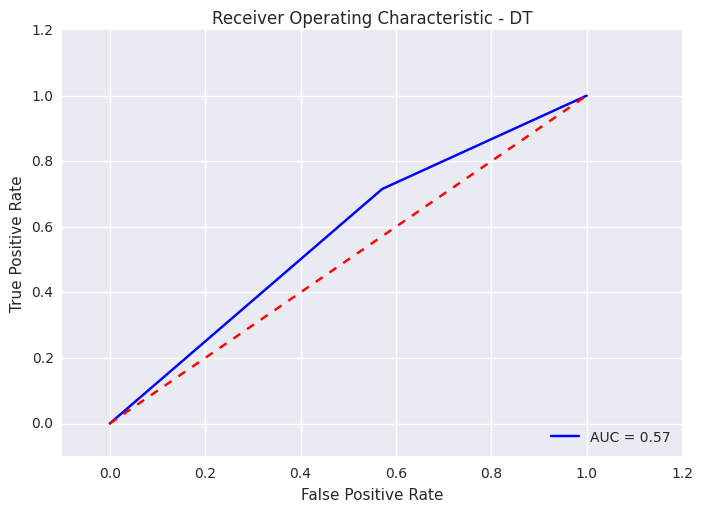

Tuning RF...
	 RF tuned!
RF had an accuracy of 76.9696969697% on the validation score
Importances 
 [ 0.19996344  0.27195742  0.08098307  0.09481362  0.04086309  0.06316107
  0.03181533  0.04989018  0.02087806  0.03960039  0.02163345  0.01997671
  0.03018703  0.03427713]


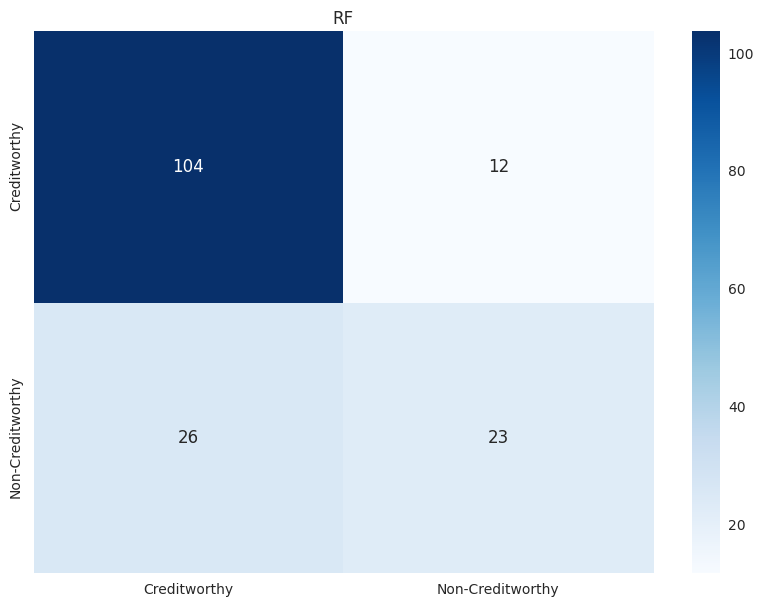

array([ 0.83,  0.22,  0.96,  0.89,  0.57,  0.54,  0.83,  0.87,  0.46,
        0.8 ,  0.96,  0.67,  0.77,  0.88,  0.67,  0.9 ,  0.81,  0.33,
        0.65,  0.74,  0.88,  0.81,  0.77,  0.33,  0.82,  0.75,  0.79,
        0.44,  0.56,  0.73,  0.78,  0.31,  0.56,  0.49,  0.96,  0.84,
        0.21,  0.93,  0.14,  0.85,  0.97,  0.79,  0.41,  0.89,  0.4 ,
        0.8 ,  0.85,  0.59,  0.77,  0.68,  0.96,  0.88,  0.89,  0.38,
        0.05,  0.82,  0.64,  0.45,  0.84,  0.92,  0.45,  0.7 ,  0.78,
        0.71,  0.63,  0.61,  0.97,  0.77,  0.84,  0.83,  0.45,  0.9 ,
        0.79,  0.99,  0.33,  0.38,  0.65,  0.82,  0.62,  0.88,  0.81,
        0.85,  0.69,  0.99,  0.73,  0.31,  0.29,  0.88,  0.36,  0.57,
        0.24,  0.28,  0.24,  0.55,  0.23,  0.62,  0.75,  0.83,  0.86,
        0.31,  0.63,  0.44,  0.51,  0.91,  0.45,  0.89,  0.14,  0.86,
        0.82,  0.91,  0.57,  0.26,  0.36,  0.6 ,  0.24,  0.72,  0.42,
        0.68,  0.93,  0.44,  0.5 ,  0.66,  0.81,  0.91,  0.8 ,  0.64,
        0.65,  0.99,

Size of X = (165, 14), 	 size of Y = (165,)
FPR: [ 0.          0.          0.04081633  0.04081633  0.04081633  0.04081633
  0.04081633  0.04081633  0.04081633  0.04081633  0.06122449  0.08163265
  0.08163265  0.12244898  0.16326531  0.18367347  0.20408163  0.2244898
  0.2244898   0.24489796  0.24489796  0.26530612  0.26530612  0.28571429
  0.28571429  0.30612245  0.30612245  0.30612245  0.36734694  0.36734694
  0.3877551   0.42857143  0.42857143  0.42857143  0.44897959  0.46938776
  0.48979592  0.51020408  0.53061224  0.53061224  0.57142857  0.6122449
  0.63265306  0.63265306  0.67346939  0.75510204  0.79591837  0.85714286
  0.89795918  0.95918367  0.97959184  1.        ] 	 TPR: [ 0.03448276  0.05172414  0.07758621  0.0862069   0.13793103  0.14655172
  0.18103448  0.20689655  0.31034483  0.34482759  0.36206897  0.38793103
  0.43965517  0.46551724  0.51724138  0.53448276  0.54310345  0.56896552
  0.57758621  0.59482759  0.60344828  0.61206897  0.64655172  0.65517241
  0.6637931   0.6724

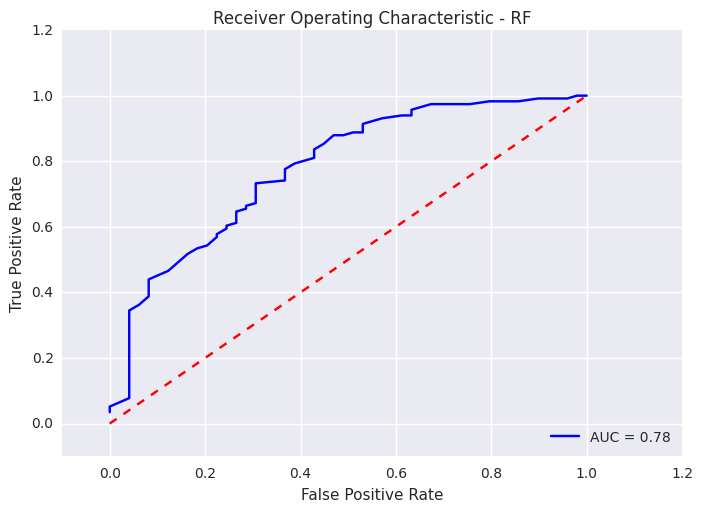

Tuning AdaBoost...
	 AdaBoost tuned!
AdaBoost had an accuracy of 77.5757575758% on the validation score
Importances 
 [ 0.12  0.66  0.04  0.02  0.    0.02  0.02  0.06  0.02  0.02  0.    0.
  0.02  0.  ]


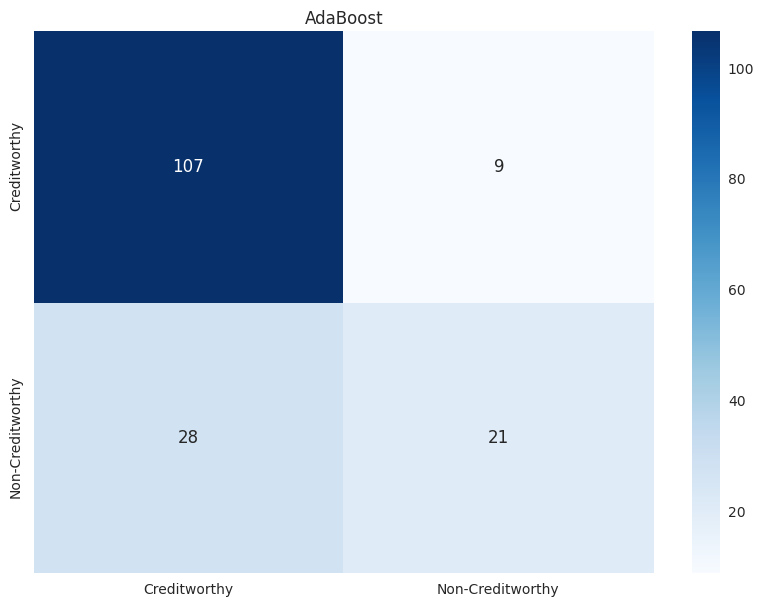

array([ 0.50597383,  0.49192067,  0.52296273,  0.51538848,  0.49899978,
        0.48973645,  0.5130084 ,  0.52166087,  0.50130226,  0.68401285,
        0.50455968,  0.50200538,  0.51721873,  0.51242971,  0.50098993,
        0.50719796,  0.5013974 ,  0.50205495,  0.5045365 ,  0.50578389,
        0.51005131,  0.51405538,  0.50597383,  0.49573231,  0.50744754,
        0.50997163,  0.51160504,  0.49167868,  0.50535248,  0.50481882,
        0.50447474,  0.48828211,  0.50562692,  0.498297  ,  0.51707166,
        0.50166203,  0.4838013 ,  0.68834716,  0.48344741,  0.50365298,
        0.50926419,  0.49944509,  0.49395603,  0.51018692,  0.48713527,
        0.5042057 ,  0.50828591,  0.50021213,  0.50825755,  0.51758083,
        0.508515  ,  0.5072371 ,  0.69725109,  0.48716602,  0.37051545,
        0.51349402,  0.50814594,  0.48892002,  0.51760042,  0.51245015,
        0.49266314,  0.50061709,  0.51652537,  0.51277951,  0.50523422,
        0.50863509,  0.51018607,  0.51089422,  0.50935023,  0.50

Size of X = (165, 14), 	 size of Y = (165,)
FPR: [ 0.          0.          0.02040816  0.02040816  0.04081633  0.06122449
  0.06122449  0.08163265  0.08163265  0.10204082  0.10204082  0.12244898
  0.12244898  0.14285714  0.14285714  0.16326531  0.16326531  0.16326531
  0.16326531  0.18367347  0.18367347  0.20408163  0.2244898   0.2244898
  0.24489796  0.24489796  0.26530612  0.26530612  0.28571429  0.28571429
  0.30612245  0.30612245  0.32653061  0.32653061  0.34693878  0.34693878
  0.34693878  0.34693878  0.3877551   0.3877551   0.42857143  0.42857143
  0.44897959  0.44897959  0.51020408  0.51020408  0.55102041  0.55102041
  0.57142857  0.57142857  0.6122449   0.6122449   0.67346939  0.67346939
  0.73469388  0.73469388  0.87755102  0.87755102  0.93877551  0.93877551
  1.        ] 	 TPR: [ 0.00862069  0.02586207  0.02586207  0.04310345  0.05172414  0.05172414
  0.06896552  0.06896552  0.13793103  0.13793103  0.24137931  0.24137931
  0.48275862  0.48275862  0.56896552  0.56896552  0.577

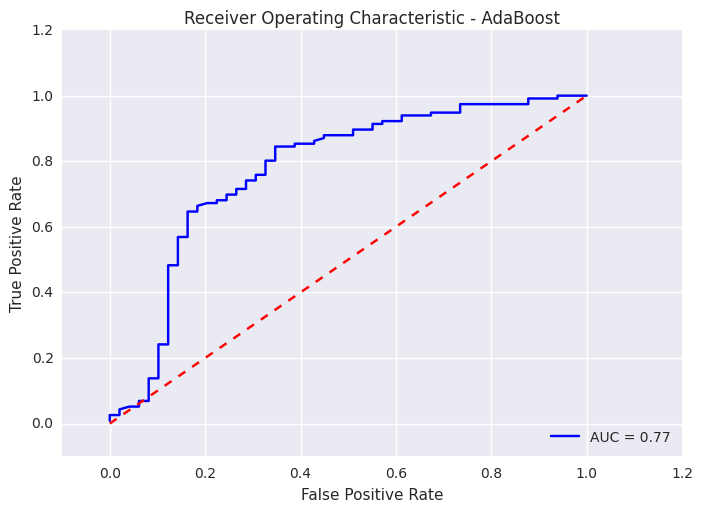

Tuning SGD...
	 SGD tuned!
SGD had an accuracy of 70.303030303% on the validation score
Importances 
 [[-2385.93866866 -9197.83096485 -1185.48990277  -779.73074046
   -643.23111444  -618.92296185  -207.55422588   104.71204188
    -97.23261032  -241.21166791  -201.94465221  -215.03365744
    -56.09573672  -216.90351533]]


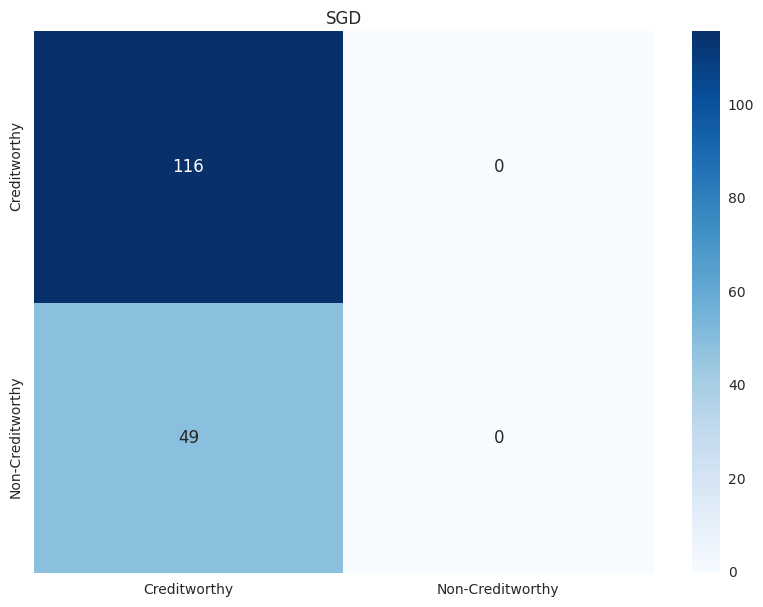

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

Size of X = (165, 14), 	 size of Y = (165,)
FPR: [ 0.  1.] 	 TPR: [ 0.  1.] 	 Thresholds = [ 2.  1.]


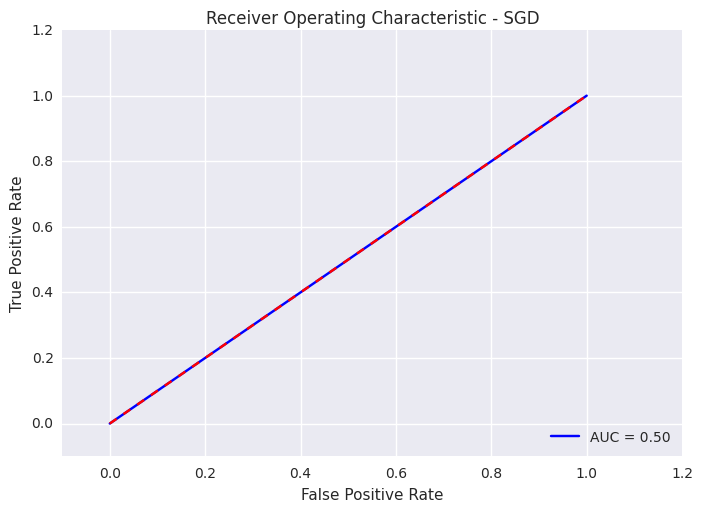

In [16]:
### breaks the train subset into pure training and validation sets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
pure_X_train, validation_X, pure_Y_train,  validation_Y = train_test_split(X_train, Y_train, test_size=0.33, random_state=1)

labelsForROC = validation_Y.copy()
# display(labelsForROC.head())
labelsForROC.ix[labelsForROC == 'Creditworthy'] = 1
labelsForROC.ix[labelsForROC == 'Non-Creditworthy'] = 0
# display(labelsForROC)

### just to be sure
# display(pure_X_train)
# display(pure_Y_train)
# print pure_X_train.shape
# print pure_Y_train.shape
# print validation_X.shape
# print validation_Y.shape    
    
### Trains all classifiers and presents the results on the validation set
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
classifiers = { 'AdaBoost' : AdaBoostClassifier(random_state = 1), 
                'SGD' : SGDClassifier(random_state = 15),
                'DT' : DecisionTreeClassifier(random_state = 1), 
                'RF' : RandomForestClassifier(random_state = 1)}
tunedClassifiers = {}
for classifierName, classifier in classifiers.iteritems():
    print 'Tuning {}...'.format(classifierName)
    tunedClassifier = tuneClassifier(classifier, pure_X_train, pure_Y_train)
    tunedClassifiers[classifierName] = tunedClassifier
    print '\t {} tuned!'.format(classifierName)
    predictions = tunedClassifier.predict(validation_X)
    acc = accuracy_score(validation_Y, predictions)

    print "{} had an accuracy of {}% on the validation score".format(classifierName, 100 * acc)
    importances = []
    if type(classifier) is SGDClassifier:
        importances = tunedClassifier.coef_
    else:
        importances = tunedClassifier.feature_importances_
    print "Importances \n {}".format(importances)
#     print "Confusion Matrix \n"
    confusionMatrix = confusion_matrix(validation_Y, predictions)
    df_cm = pd.DataFrame(confusionMatrix, index = ["Creditworthy", "Non-Creditworthy"],
                  columns = ["Creditworthy", "Non-Creditworthy"])
    plt.figure(figsize = (10,7))
    sns.plt.title(classifierName)
    sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.show()
    
    
    ### ROC CURVE
    probas_ = tunedClassifier.predict_proba(validation_X)
    probas_ = probas_[:,0]
    display(probas_)
    print "Size of X = {}, \t size of Y = {}".format(validation_X.shape, validation_Y.shape)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(labelsForROC, probas_)
    print "FPR: {} \t TPR: {} \t Thresholds = {}".format(false_positive_rate, true_positive_rate, thresholds)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    plt.title('Receiver Operating Characteristic - {}'.format(classifierName))
    plt.plot(false_positive_rate, true_positive_rate, 'b',
    label='AUC = %0.2f'% roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.1,1.2])
    plt.ylim([-0.1,1.2])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    

In [ ]:
### Gets the list of attributes for the table in the report
# print df_training.columns.values

### Applies each of the tuned classifiers to the test set

In [ ]:
# print df_test.columns.values
for classifierName, classifier in tunedClassifiers.iteritems():
    if type(classifier) is AdaBoostClassifier:
        predictions = classifier.predict(X_test)        
        worthy = np.where(predictions == 'Creditworthy')[0].size
        print 'Worthy = {} and Non-worthy = {}'.format(worthy, X_test.shape[0]-worthy)

### Computing ROC Curves for Test Data

In [ ]:
from sklearn.metrics import roc_curve, auc
